In [1]:
# Import required packages for pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Import required libraries
import pandas as pd
from bs4 import BeautifulSoup
import re
import contractions
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Constructing a custom transformer for data preprocessing
class CleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    # Removing the HTML tags
    def remove_html_tags(self,text):
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text(separator=" ")
        return text

    # Removing the URLS from text
    def remove_links(self,text):
        text = re.sub(r'https?:\/\/.*[ ]*', '', text)
        return text

    # Converting non-ascii
    def transform_nonascii(self,text):
        return ''.join(char for char in text if ord(char) < 128)

    # Removing numbers
    def remove_numbers(self,text):
        return re.sub(r'[0-9]+', '', text)

    # Removing slashes
    def remove_slash(self,text):
        return re.sub(r'[\n,\b,\t]', '', text)

    # Removing contractions
    def remove_contractions(self,text):
        return contractions.fix(text)

    # Removing non-alphanumerics:
    def remove_nonalpha(self,text):
        text = re.sub(r'[^\w]', ' ', text)
        text = re.sub(r'_', '', text)
        return text

    # Removing words with less words
    def remove_less_characters(self,text):
        return re.sub(r'\b\w{1,2}\b', '', text)

    # Unwanted spaces:
    def remove_space(self,text):
        return re.sub(r' +', ' ', text)

    def transform(self,X,y=None):
        X = X.apply(self.remove_html_tags)
        X = X.apply(self.transform_nonascii)
        X = X.apply(self.remove_numbers)
        X = X.apply(self.remove_links)
        X = X.apply(self.remove_slash)
        X = X.apply(self.remove_contractions)
        X = X.apply(self.remove_nonalpha)
        X = X.apply(self.remove_less_characters)
        X = X.apply(self.remove_space)
        X = X.str.lower()
        return X

In [3]:
class StopWordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    # Stop words removal
    def remove_stop_words(self,text):
        removed_list = []
        for token in text.split():
            if token not in stopwords.words('english'):
                removed_list.append(token)

        return " ".join(removed_list)

    def transform(self,X,y=None):
        return X.apply(self.remove_stop_words)

In [4]:
class StemmingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    # Stemming
    def stemming(self,text):
        ps = PorterStemmer()
        return " ".join([ps.stem(word) for word in word_tokenize(text)])

    def transform(self,X,y=None):
        return X.apply(self.stemming)

In [5]:
clean_transformer = CleanTransformer()
stop_words = StopWordsTransformer()
stemming_transformer = StemmingTransformer()

with open('binfiles/vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

with open('binfiles/model_lr.pkl', 'rb') as file:
    model = pickle.load(file)

C:\Users\ram\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\ram\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
model_pipeline = Pipeline([('clean_transformer', clean_transformer), ('stop_words', stop_words),
                           ('stemming_transformer', stemming_transformer), ('vectorizer', vectorizer),
                           ('model', model)])

In [7]:
df_test = pd.read_csv('Data/test_data.csv')

In [8]:
predicted_labels = model_pipeline.predict(df_test['text'])

In [9]:
def process_label(label):
    for idx in range(len(label)):
        # Positive if stars are above 4
        if label[idx] >= 4:
            label[idx] = 1
        # Negative if starts are below 2
        elif label[idx] <= 2:
            label[idx] = -1
        # Neutral if starts is 3
        else:
            label[idx] = 0

    return label

In [10]:
test_y = df_test['stars'].to_numpy()
test_y = process_label(test_y)

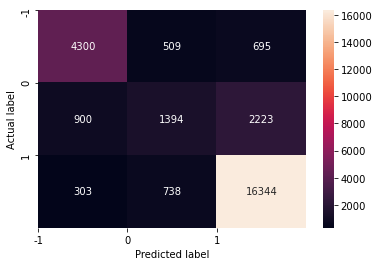

In [11]:
# Import confusion matrix
from sklearn.metrics import confusion_matrix

cmatrix = confusion_matrix(test_y,predicted_labels)
class_names=['-1','0','1'] # name  of classes
# create heatmap
sns.heatmap(pd.DataFrame(cmatrix, columns=class_names), annot=True, fmt='g')
plt.xticks(range(3),['-1','0','1'])
plt.yticks(range(3),['-1','0','1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(test_y,predicted_labels)
f1_score = f1_score(test_y,predicted_labels, average='weighted')

print(f'Accuracy for the test set is {accuracy}')
print(f'F1 score for the test set is {f1_score}')

Accuracy for the test set is 0.8041304823761221
F1 score for the test set is 0.7869307112489586
